In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjectiveGO import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
#     print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    if len(useable)>=2:
        n_plots = 3
    else:
        n_plots = 2
    plt.subplot(1, n_plots, 1)
    plt.plot(xall,res["logz"])
    if any([lnz<=0 for lnz in res["logz"]]):
        plt.title("ln(evidence)\n not log scaled vs -ln(X)")
        plt.plot(xall, [0 for value in xall], label="ln(evidence)=0", alpha=0.4,linestyle="--")
    else:
        plt.title("ln(evidence)\n log scaled vs -ln(X)")
        plt.yscale("log")
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
#     plt.figure(figI)
#     figI+=1
    plt.subplot(1, n_plots, 2)
    plt.plot(interesting[0],interesting[1])
    plt.title("interesting values\n ln(evidence)\n"+r" vs -ln(X) $\geq %d$" % interestingNo)
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
    if len(useable)>=2:
        plt.subplot(1, n_plots, 3)
        plt.plot(useable[0],useable[1])
        plt.title("usful values\n"+r"ln(%.3f<evidence $\leq$ %.3f) vs -ln(X)"%(useAbleLow,useAbleHigh))
        plt.xlabel("-ln(X)")
        plt.ylabel("ln(evidence)")
    else:
        print("not enough 'usable' data points")
    print(figI)
    plt.tight_layout()
    return figI

In [3]:
# def min_interesting_lnX(res):
#     returns = None
# #     returns = min([-lnX for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0])
#     returns = [(-lnX,wt) for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0.001]
#     return returns

def min_interesting_lnX(res):
    returns = None
    for lnX, logz in zip(res["logvol"], res['logz']):
        if logz >= 0.:
            break
        else:
            returns = -lnX
#     returns = min([-lnX for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0])
    return returns

maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [4]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
# no_layers = len(bs_true)
# no_layers = 3
layers1 = []
layers2 = []
names = []
#names = ['layer1','layer2']
contrast_layer = 1
bs_contrast_layer = 6
thicks_contrast_layer=Parameter(thicks[contrast_layer],
                                "layer1 thickness")
roughs_contrast_layer=Parameter(roughs[contrast_layer],
                                "layer0/contrast roughness")
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
    if i != contrast_layer:
        sld = SLD(bs[i],name=names[i])
        sld = sld(thicks[i],roughs[i])
        layers1.append(sld)
        layers2.append(sld)
    else:
        sld1 = SLD(bs[i],name=names[i]+" contrast a")
        sld1 = sld1(thicks_contrast_layer,roughs_contrast_layer)
        sld2 = SLD(bs_contrast_layer,name=names[i]+" contrast b")
        sld2 = sld2(thicks_contrast_layer,roughs_contrast_layer)
        layers1.append(sld1)
        layers2.append(sld2)

structure1 = layers1[0]
for layer in layers1[1:]:
    structure1|=layer

structure2 = layers2[0]
for layer in layers2[1:]:
    structure2|=layer
print("done")

done


done


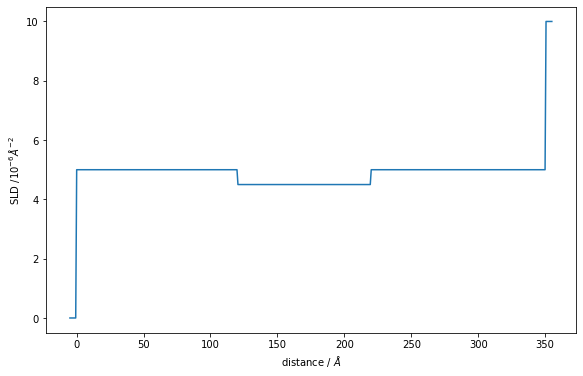

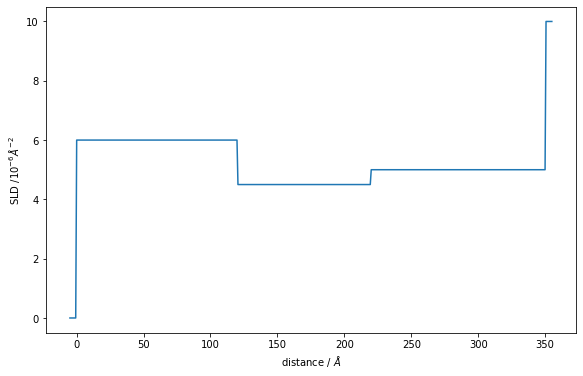

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*structure1.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

plt.figure(figI)
figI+=1
plt.plot(*structure2.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [6]:
resolution = 5.
model1 = ReflectModel(structure1, bkg=3e-6, dq=resolution)
model2 = ReflectModel(structure2, bkg=3e-6, dq=resolution)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


<ErrorbarContainer object of 3 artists>

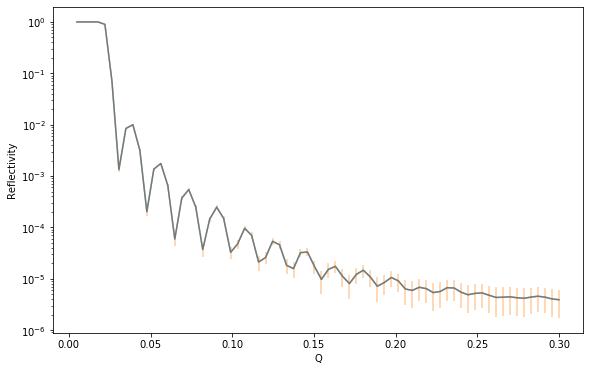

In [7]:
q = np.linspace(0.005, 0.3, 70)# was 1001 no 70
plt.figure(figI)
figI+=1
R1 = model1(q, x_err=resolution)
plt.plot(q, R1)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
sim_dR1 = msd.main(sim_q=q,sim_R=R1)*10
plt.errorbar(q,R1,sim_dR1, alpha=0.4)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


<ErrorbarContainer object of 3 artists>

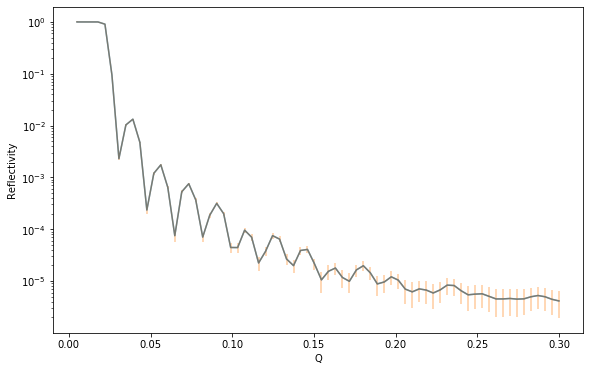

In [8]:
q = np.linspace(0.005, 0.3, 70)# was 1001 no 70
plt.figure(figI)
figI+=1
R2 = model2(q, x_err=resolution)
plt.plot(q, R2)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
sim_dR2 = msd.main(sim_q=q,sim_R=R2)*10
plt.errorbar(q,R2,sim_dR2, alpha=0.4)

In [9]:
data = [Data1D(data= (q,R1,sim_dR1)),Data1D(data= (q,R2,sim_dR2))]

# # from sepObjective import getObjective as gO
# objective = gO(data, 3)
# # from CFitter import CFitter
# # def ex
# fitter = CFitter(objective)
# # from dynesty import DynamicNestedSampler
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.01)
# res = DNSampler.results # 07:18 mins


# res.summary()

summary() doesnt seem useable for dynamic sampling.\
MultiEllipsoidSamplerSamples conditioned on the union of multiple (possibly overlapping) ellipsoids used to bound the set of live points.



calculation is taking ln(z) = ln(evidence) and taking the exponent

In [10]:
# fig, ax = objective.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**1)]
# fig, axes = dyplot.runplot(res,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

# figI = aPlotter(res, 19, 35, figI)

# fig, axes = dyplot.traceplot(res, truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None,
#                            logplot=False)
# fig.tight_layout()

## test 3 layered

In [11]:
objective1, structure11, structure12 = gO(data, 3, both=True, globalObjective=True) # was 06:09 now 0:36
# fitter = CFitter(objective1)
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.05) # was 0.01
# res11 = DNSampler.results

objective11, structure111, structure112 = gO(data, 3, both=True, globalObjective=True) # was 06:09 now 0:36
fitter = CFitter(objective11)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res11 = DNSampler.results

# objective2, structure21, structure22 = gO(data, 3,
#                  logpExtra=logp_extra, both=True, globalObjective=True)
# fitter = CFitter(objective2)
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.05) # was 0.01
# res12 = DNSampler.results

data, nLayers, bs_contrast_layer=None,
 contrast_layer=None,
limits = None, doMCMC=False,
logpExtra=None, onlyStructure=False,
both=False, globalObjective=False:  [Data1D(data=(array([0.005     , 0.00927536, 0.01355072, 0.01782609, 0.02210145,
       0.02637681, 0.03065217, 0.03492754, 0.0392029 , 0.04347826,
       0.04775362, 0.05202899, 0.05630435, 0.06057971, 0.06485507,
       0.06913043, 0.0734058 , 0.07768116, 0.08195652, 0.08623188,
       0.09050725, 0.09478261, 0.09905797, 0.10333333, 0.1076087 ,
       0.11188406, 0.11615942, 0.12043478, 0.12471014, 0.12898551,
       0.13326087, 0.13753623, 0.14181159, 0.14608696, 0.15036232,
       0.15463768, 0.15891304, 0.16318841, 0.16746377, 0.17173913,
       0.17601449, 0.18028986, 0.18456522, 0.18884058, 0.19311594,
       0.1973913 , 0.20166667, 0.20594203, 0.21021739, 0.21449275,
       0.21876812, 0.22304348, 0.22731884, 0.2315942 , 0.23586957,
       0.24014493, 0.24442029, 0.24869565, 0.25297101, 0.25724638,
       0.26152174, 

       2.23290716e-06, 2.19196922e-06]), None), mask=None), lnsigma=None, use_weights=True, transform=Transform('logY'), logp_extra=None, name=1800569761128)]), Structure(components=[Slab(Parameter(value=10.0, name='air layer - thick', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), SLD([Parameter(value=0.0, name='air layer - sld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name='air layer - isld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)], name='air layer'), Parameter(value=0.0, name='air layer - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='air layer', vfsolv=Parameter(value=0.0, name='air layer - volfrac solvent', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)), Slab(Parameter(value=116.66666666666667, name='layer1 thickness', vary=True, bounds=Interval(lb=50, ub=200.0), constraint=None), SLD([Parameter(value=5.0, name='contras

       2.23290716e-06, 2.19196922e-06]), None), mask=None)] 3 6 1 None False None False True True
1111
(GlobalObjective([Objective(ReflectModel(Structure(components=[Slab(Parameter(value=10.0, name='air layer - thick', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), SLD([Parameter(value=0.0, name='air layer - sld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name='air layer - isld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)], name='air layer'), Parameter(value=0.0, name='air layer - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='air layer', vfsolv=Parameter(value=0.0, name='air layer - volfrac solvent', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)), Slab(Parameter(value=116.66666666666667, name='layer1 thickness', vary=True, bounds=Interval(lb=50, ub=200.0), constraint=None), SLD([Parameter(value=5.0, name='contrast A layer - sld',

       2.23290716e-06, 2.19196922e-06]), None), mask=None), lnsigma=None, use_weights=True, transform=Transform('logY'), logp_extra=None, name=1800569958240)]), Structure(components=[Slab(Parameter(value=10.0, name='air layer - thick', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), SLD([Parameter(value=0.0, name='air layer - sld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name='air layer - isld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)], name='air layer'), Parameter(value=0.0, name='air layer - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='air layer', vfsolv=Parameter(value=0.0, name='air layer - volfrac solvent', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)), Slab(Parameter(value=116.66666666666667, name='layer1 thickness', vary=True, bounds=Interval(lb=50, ub=200.0), constraint=None), SLD([Parameter(value=5.0, name='contras

8029it [12:23,  8.84it/s, batch: 0 | bound: 99 | nc: 25 | ncall: 176228 | eff(%):  4.543 | loglstar:   -inf < 127.334 <    inf | logz: 108.503 +/-  0.267 | dlogz: 70.887 >  0.050]     C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
8405it [13:11,  8.45it/s, batch: 0 | bound: 105 | nc: 25 | ncall: 186419 | eff(%):  4.497 | loglstar:   -inf < 139.849 <    inf | logz: 120.413 +/-  0.272 | dlogz: 58.222 >  0.050] C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extreme

10615it [18:44, 11.97it/s, batch: 0 | bound: 154 | nc: 25 | ncall: 275537 | eff(%):  3.845 | loglstar:   -inf < 185.939 <    inf | logz: 163.059 +/-  0.295 | dlogz: 28.038 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
10646it [18:54, 10.82it/s, batch: 0 | bound: 156 | nc: 25 | ncall: 278525 | eff(%):  3.815 | loglstar:   -inf < 186.323 <    inf | logz: 163.383 +/-  0.295 | dlogz: 27.652 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inef

In [12]:
print(objective1)
fitter = CurveFitter(objective1)
fitter.fit('differential_evolution')

_______________________________________________________________________________

--Global Objective--
________________________________________________________________________________
Objective - 1800569759448
Dataset = <None>, 70 points
datapoints = 70
chi2 = 84.15153607761471
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1          , bounds=[0.85, 1.2]>
<Parameter:     'bkg'     , value=3e-06          , bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:   'air layer'  
<Parameter:'air layer 

   covar: array([[ 1.13220080e-05, -2.07423060e-12,  7.19114725e-05,
        -2.80776779e-05, -8.70339995e-04,  1.44152364e-05,
         8.38330916e-04,  2.36263219e-05,  2.75878821e-07,
         1.75257023e-11,  6.66211356e-06],
       [-2.07423060e-12,  2.29006690e-13, -5.53447142e-09,
        -8.94546944e-10, -6.06615913e-08,  2.31118023e-09,
         7.06742177e-08,  1.51287827e-09,  1.72457154e-11,
         1.58841374e-15,  5.99297645e-10],
       [ 7.19114725e-05, -5.53447142e-09,  1.12298933e+00,
        -5.78011688e-03, -1.79436824e+00, -2.82428096e-02,
         6.75927512e-01, -3.81003801e-03,  2.92134868e-05,
        -3.76790582e-09, -9.36112412e-03],
       [-2.80776779e-05, -8.94546944e-10, -5.78011688e-03,
         2.93868134e-03,  2.49144530e-04,  1.64410982e-03,
         1.32172248e-02,  1.98275711e-03,  1.64800184e-05,
         1.09692720e-09,  8.80566391e-04],
       [-8.70339995e-04, -6.06615913e-08, -1.79436824e+00,
         2.49144530e-04,  9.23837196e+00, -6.608851

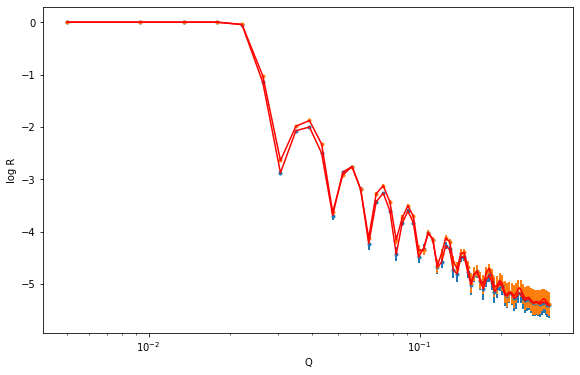

In [13]:
objective1.plot()
# plt.legend()
plt.xlabel('Q')
plt.ylabel('log R')
plt.xscale('log');

previous\
21713it [04:36, 78.66it/s, batch: 9 | bound: 66 | nc: 1 | ncall: 64560 | eff(%): 33.632 | loglstar: -1811.602 < -1805.361 < -1805.882 | logz: -1818.340 +/-  0.211 | stop:  0.955]\
pre previous\
25968it [06:09, 70.27it/s, batch: 10 | bound: 81 | nc: 1 | ncall: 75806 | eff(%): 34.256 | loglstar: -44363.849 < -44357.543 < -44357.955 | logz: -44375.162 +/-  0.250 | stop:  0.975] 

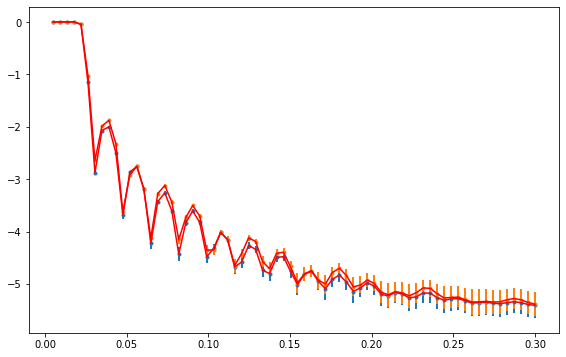

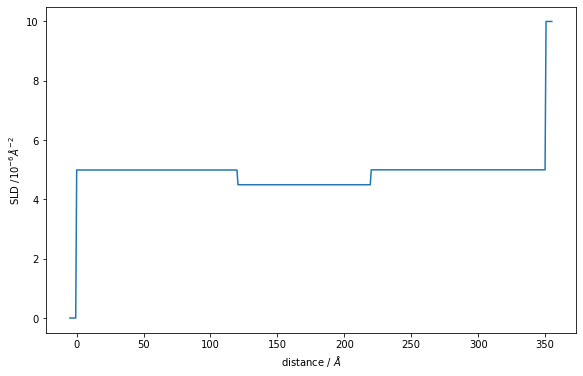

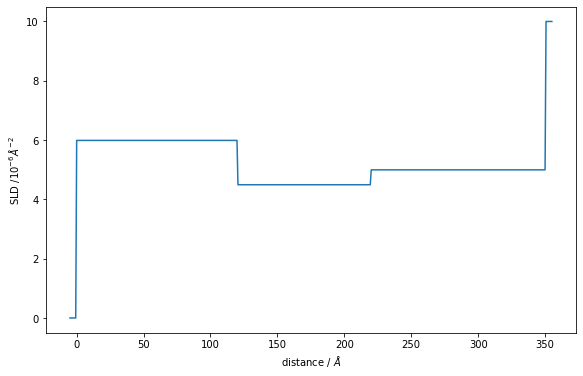

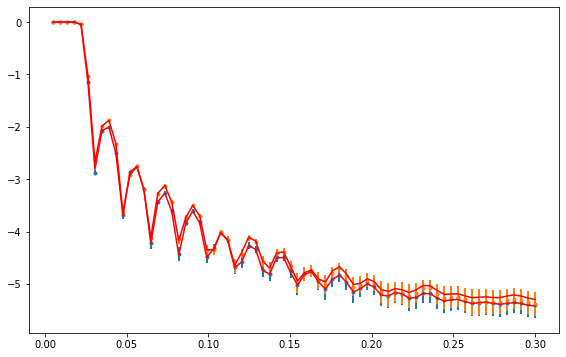

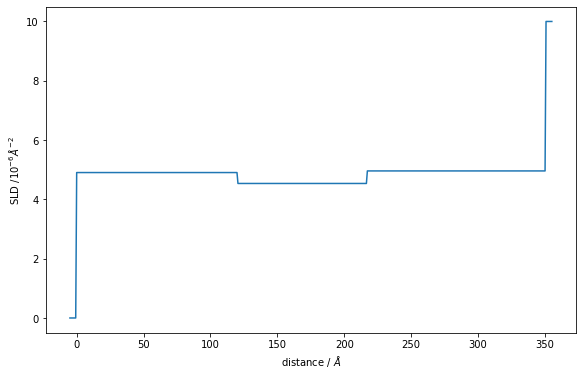

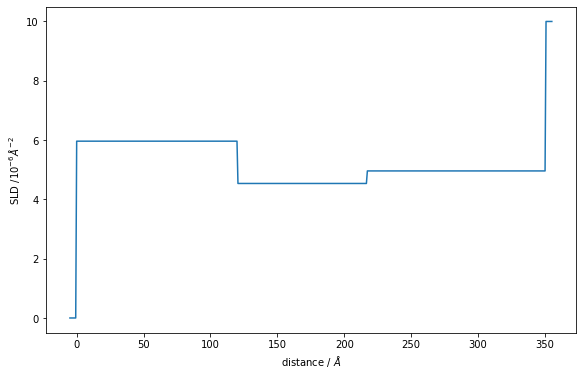

In [14]:
fig, ax = objective1.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure11.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure12.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

fig, ax = objective11.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure111.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure112.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

# fig, ax = objective2.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure21.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure22.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');